<a href="https://colab.research.google.com/github/JuliethLopez/chatbot_simpsons/blob/master/Copia_de_BBC_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación usando Lenguaje Natural

In [43]:
#librerias
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as plt
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras import layers, backend

In [ ]:
# pip install nltk

In [ ]:
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [44]:
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize

# Define algunas características iniciales

In [66]:
vocab_size = 26000 # número de palabras que integrarán el vocabulario
embedding_dim = 32 # dimensión del embeding de las palabras
max_length = 111  # longitud máxima de una oración (sentence filtrada con stopwords)
trunc_type='post' # donde truncar una oración (sentence, filtrada con stopwords)
padding_type='post'# donde hacer el padding (agregar ceros) en una oración (sentence, filtrada con stopwords)
oov_tok = "<OOV>"  # token para las palabras que queden fuera del vocabulario
training_portion = .8  # porcentaje de datos para entrenamiento

In [47]:
complete_sentences = []
complete_lines = [] 
sentences = []
labels = [] # preprocesed labels

stopwords = []
print(len(stopwords))

0


In [48]:
import string
import numpy as np

a = np.array([32]) # space
#b = np.array(range(65,91)) # uppercase
c = np.array(range(97,123)) # lowercase
printab = np.hstack((a,c))

printable = np.array([chr(i) for i in printab])   
printable

#ascci_to_char = dict((printab[i], printable[i]) for i in range(len(printable)))

array([' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
       'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
       'z'], dtype='<U1')

In [49]:
#lectura de los datos
import string
import re #regular expresions
# abre el archivo de datos y lo trata como un archivo csv
file = open('DFSMS.csv', 'r')
with file as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        # preprocess label
        #label_l = ' '.join(row[0].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
        label_l = re.sub(' +', ' ',row[0].lower()) # lower case ans eliminate multiple spaces
        if (len(label_l)>2): # drop with empty label
            label = ''.join(c for c in label_l if c in printable)# filter only printable characters
            label = label.replace(' ','_')
            labels.append(label)
            # preprocess sentence
            #sentence_l = ' '.join(row[1].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
            sentence_l = re.sub(' +', ' ',row[1].lower())
            sentence = ''.join(c for c in sentence_l if c in printable)
            complete_lines.append(row[0] + ': '+ row[1])
            complete_sentences.append(sentence)
            # preprocess stopwords
            for word in stopwords:
                token = " " + word + " "
                sentence = sentence.replace(token, " ")
            sentences.append(sentence)
 

# resumen de la lectura            
print(len(labels))
print(len(complete_sentences))
print(len(complete_lines))
print(len(sentences))


69171
69171
69171
69171


In [50]:
# Primera linea
print(labels[0]+'\n')
print(complete_sentences[0]+'\n')
print(complete_lines[0]+'\n')
print(sentences[0]+'\n')


lisa_simpson

wheres mr bergstrom

Lisa Simpson: Where's Mr. Bergstrom?

wheres mr bergstrom



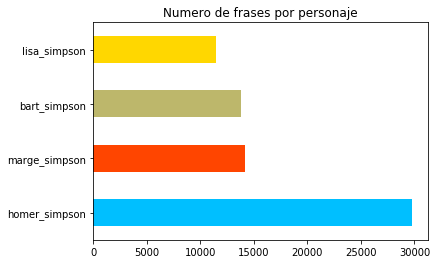

In [51]:
#Gráfico de barras de numero de frases por personaje
frec = pd.value_counts(labels)
plot = frec.plot(kind='barh',title='Numero de frases por personaje',color=['deepskyblue','orangered','darkkhaki','gold'])

In [52]:
sentences[:4]

['wheres mr bergstrom',
 'that life is worth living',
 'victory party under the slide',
 'mr bergstrom mr bergstrom']

# Separa datos de entrenamiento y validación 

In [53]:
train_size = int(len(sentences) * training_portion)

#train_sentences = sentences[:train_size]
train_sentences = sentences
#train_labels = labels[:train_size]
train_labels = labels

#validation_sentences = sentences[train_size:]
#validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
#print(len(validation_sentences))
#print(len(validation_labels))



55336
69171
69171


In [54]:
train_sentences[:3]

['wheres mr bergstrom',
 'that life is worth living',
 'victory party under the slide']

In [55]:
train_labels[:3]

['lisa_simpson', 'lisa_simpson', 'bart_simpson']

# Tokens

In [57]:
#Juntamos todo el texto en una sola linea
wordtk = ' '.join(train_sentences)

In [58]:
#Para dividir las frases
tokenstk = regexp_tokenize(wordtk, pattern="\w+")
tokenstk[:10]

['wheres',
 'mr',
 'bergstrom',
 'that',
 'life',
 'is',
 'worth',
 'living',
 'victory',
 'party']

In [59]:
#para generar n-gramas
from nltk.util import ngrams
trigrama = ngrams(tokenstk,3)
trigrama = [' '.join(grams) for grams in trigrama]
trigrama[:5]

['wheres mr bergstrom',
 'mr bergstrom that',
 'bergstrom that life',
 'that life is',
 'life is worth']

In [60]:
len(trigrama)

600573

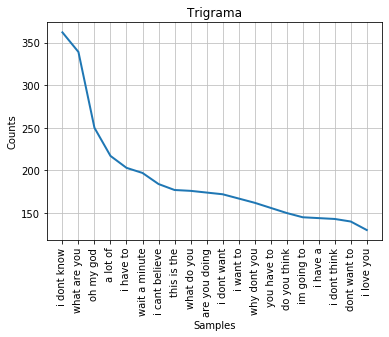

In [61]:
#Gráfica con los trigramas

freq = nltk.FreqDist(trigrama) #Frecuencia de los tokens
freqnew = [] #Filtramos tokens que se repiten mas de una vez
for key,val in freq.items():
  if (val>1):
    freqnew.append(str(key))
freq.plot(20, cumulative=False, title = "Trigrama")

In [17]:
#len(freqnew)

37069

# Vocabulario

In [62]:
corpus=train_sentences

In [63]:
tokenizer=Tokenizer()

In [64]:
tokenizer.fit_on_texts(corpus)

In [67]:
total_words = len(tokenizer.word_index)+1
print(total_words)


26000


In [69]:
#print('Dictionary: ',tokenizer.word_index,'\n')

In [70]:
print('Total Words in the Tokenizer (+OOV) =',total_words,'\n')

Total Words in the Tokenizer (+OOV) = 26000 



In [71]:
print('Corpus: \n')
corpus[0:10]

Corpus: 



['wheres mr bergstrom',
 'that life is worth living',
 'victory party under the slide',
 'mr bergstrom mr bergstrom',
 'do you know where i could find him',
 'the train how like him traditional yet environmentally sound',
 'i see he touched you too',
 'hey thanks for your vote man',
 'well you got that right thanks for your vote girls',
 'well dont sweat it just so long as a couple of people did right milhouse']

In [72]:
print(tokenizer.word_index['where'])
print(tokenizer.word_index['living'])
print(tokenizer.word_index['girls'])
print(tokenizer.word_index['people'])
print(tokenizer.word_index['thanks'])

116
577
530
133
202


In [73]:
test_seq = []

In [74]:
print('First Line = ',corpus[0],'\n')

First Line =  wheres mr bergstrom 



In [75]:
token_test=tokenizer.texts_to_sequences([corpus[0]])[0]
print('First Line into Sequence =',token_test,'\n')

First Line into Sequence = [361, 146, 2229] 



In [100]:
# Ejemplo:
# wheres mr bergstrom 

test_seq = []

# Primera línea en el corpus
print('First Line = ',corpus[0],'\n')

# Transforma la primera línea del corpus en secuencias deacuerdo con el diccionario

token_test=tokenizer.texts_to_sequences([corpus[0]])[0]
print('First Line into Sequence =',token_test,'\n')

# Crea fragmentos de la línea y crea los datos por piezas ordenadas
for j in range(1, len(token_test)):
  # Iterador sobre los elementos de la línea.
  n_gram_test=token_test[:j+1]
  print('n-gram =',n_gram_test)
  # Añade todos los resultados secuenciales
  test_seq.append(n_gram_test)
  print('sequence = ',test_seq,'\n')

# Determina el n-grama más extenso
max_seq_test_len = max([len(x) for x in test_seq])
# Relleno
test_seq = np.array(pad_sequences(test_seq, maxlen=max_seq_test_len, padding='pre'))
print("Final n-gram Data:\n\n",  test_seq,'\n')
print('Shape of Data: ',np.shape(test_seq))

First Line =  wheres mr bergstrom 

First Line into Sequence = [361, 146, 2229] 

n-gram = [361, 146]
sequence =  [[361, 146]] 

n-gram = [361, 146, 2229]
sequence =  [[361, 146], [361, 146, 2229]] 

Final n-gram Data:

 [[   0  361  146]
 [ 361  146 2229]] 

Shape of Data:  (2, 3)


In [79]:
# Crear la secuencia de texto para crear datos de entrenamiento 

input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)
    

# Relleno

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Cree predictores y etiquetas (las etiquetas son la palabra final de cada secuencia. Ex: Datos: wheres mr bergstrom, Personaje: )

xs = input_sequences[:,:-1]
label_size = 500
label_tokenizer = Tokenizer(num_words = label_size,oov_token=oov_tok, filters = '')
label_tokenizer.fit_on_texts(labels)
label_seq = np.array(label_tokenizer.texts_to_sequences(labels))
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))

# flatten the nested list and tranaform to an np array
label_seq = np.array([item for items in label_seq for item in items])
training_label_seq = np.array([item for items in training_label_seq for item in items])

from sklearn. preprocessing import LabelEncoder
#preprocessing.LabelEncoder()
encoder = LabelEncoder()

encoder.fit(label_seq)
y_train = encoder.transform(training_label_seq)
num_classes = np.max(y_train) + 1



In [124]:
print(input_sequences[7])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 2305  375  513]


In [112]:
labels=input_sequences[:,-1]
print(labels)

[ 146 2229  160 ...  409    2  333]


In [80]:
 # Codificación One-Hot 

ys = tf.keras.utils.to_categorical(y_train, num_classes)

In [98]:
print(input_sequences)

[[   0    0    0 ...    0  361  146]
 [   0    0    0 ...  361  146 2229]
 [   0    0    0 ...    0    9  160]
 ...
 [   0    0    0 ...   22    8  409]
 [   0    0    0 ...    8  409    2]
 [   0    0    0 ...  409    2  333]]


In [96]:
len(ys)

69171

In [81]:
# Example 
print(corpus[0],'\n')
print(xs[3],'->',labels[3],'\n')
print('One Hot Encoding:\n\n',ys[3])

wheres mr bergstrom 

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   9 160] -> lisa_simpson 

One Hot Encoding:

 [0. 0. 0. 1.]


In [82]:
# Tensor Management
import tensorflow as tf
# For Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
# For Different Types of RNN
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
# For Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
# Sequential DNN
from tensorflow.keras.models import Sequential
# Array Management
import numpy as np

In [94]:
model = Sequential()
model.add(Embedding(total_words, 32, input_length = max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(120,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics =['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 110, 32)           832000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 40)                8480      
_________________________________________________________________
dense_8 (Dense)              (None, 120)               4920      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 484       
Total params: 845,884
Trainable params: 845,884
Non-trainable params: 0
_________________________________________________________________


In [92]:
history = model.fit(xs,ys,epochs=20,verbose=True)

ValueError: Input arrays should have the same number of samples as target arrays. Found 535815 input samples and 69171 target samples.

### Ejemplo con 7 frases

In [ ]:
train_sentences[:7]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer3 = CountVectorizer(analyzer='word', ngram_range=(3,3))

In [ ]:
X = vectorizer3.fit_transform(train_sentences[:7])
X

In [ ]:
F = vectorizer3.get_feature_names() #Array mapping from feature integer indices to feature name.
vectorizer3.decode(F) #Decode the input into a string of unicode symbols.

In [88]:
print('Vocabulary:')
print(vectorizer3.vocabulary_)

Vocabulary:


NameError: ignored

In [ ]:
print("arreglo",X.toarray())
print("longitud",len(X.toarray()))

In [ ]:
import pandas as pd
pd.DataFrame(X.toarray(),columns=vectorizer3.get_feature_names())

In [ ]:
#función inversa
print('To the source:')
print(vectorizer3.inverse_transform(X.toarray()))

### Para todos los datos

In [ ]:
#usamos CountVectorizer para convertir un texto en una matriz de tokens contados
from sklearn.feature_extraction.text import CountVectorizer

vectorizer3 = CountVectorizer(analyzer='word', ngram_range=(3,3))

In [ ]:
#Learn the vocabulary dictionary and return document-term matrix.
X = vectorizer3.fit_transform(train_sentences)
X

In [ ]:
F = vectorizer3.get_feature_names() #Array mapping from feature integer indices to feature name.
#vectorizer3.decode(F) #Decode the input into a string of unicode symbols.

In [ ]:
#imprime el vector final
#X.toarray()

In [ ]:
# Now, we can inspect how our vectorizer vectorized the text
# This will print out a list of words used, and their index in the vectors
print('Vocabulary: ')
print(vectorizer3.vocabulary_)

In [ ]:
#tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok,split= ' ')
#tokenizer.fit_on_texts(train_sentences)
#word_index = tokenizer.word_index

#train_sequences = tokenizer.texts_to_sequences(train_sentences)
#train_padded = np.array(pad_sequences(train_sequences, padding=padding_type, maxlen=max_length))

In [ ]:
#word_index

In [ ]:
print((train_sequences[0]))
print(len(train_padded[0]))

#print(len(train_sequences[1]))
#print(len(train_padded[1]))

#print(len(train_sequences[10]))
#print(len(train_padded[10]))

# Expected Ouput
# 12
# 120
# 3
# 120
# 10
# 120

In [ ]:
train_sequences[:2]

In [ ]:
train_padded[:2]

In [ ]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = np.array(pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length))


In [ ]:
validation_sequences[:2]

# Expected output
# 31663
# (31663, 120)

In [ ]:
validation_padded[:2]

In [ ]:
print(len(validation_sequences))
print(validation_padded.shape)

# Expected output
# 31663
# (31663, 120)

In [ ]:
label_size = 500
#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
label_tokenizer = Tokenizer(num_words = label_size,oov_token=oov_tok, filters = '')
label_tokenizer.fit_on_texts(labels)

label_seq = np.array(label_tokenizer.texts_to_sequences(labels))
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq[3])
print(training_label_seq[5])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq[3])
print(validation_label_seq[5])
print(validation_label_seq.shape)

# Expected output
# [4]
# [2]
# [1]
# (1780, 1)
# [5]
# [4]
# [3]
# (445, 1)

In [ ]:
# flatten the nested list and tranaform to an np array
label_seq = np.array([item for items in label_seq for item in items])
training_label_seq = np.array([item for items in training_label_seq for item in items])
validation_label_seq = np.array([item for items in validation_label_seq for item in items])


In [ ]:
label_seq[:5]

In [ ]:
max(validation_label_seq)

# transform target to one-hot codification

## primero crea etiquetas numéricas

In [ ]:
from sklearn. preprocessing import LabelEncoder
#preprocessing.LabelEncoder()
encoder = LabelEncoder()

encoder.fit(label_seq)
y_train = encoder.transform(training_label_seq)
y_test = encoder.transform(validation_label_seq)

In [ ]:
max(y_train)

In [ ]:
y_train.shape

In [ ]:
y_train

In [ ]:
y_test

## one hot

In [ ]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
num_classes

In [ ]:
y_train.shape

In [ ]:
y_train[0]

In [ ]:
y_test[0]

## Modelo 1

| dropout | conv1D | LSTM | accuracyTrain | accuracyValidation | epoch |
|---------|:------:|:----:|:-------------:|:------------------:|:-----:|
|         |        |      |    0.3645     |       0.3478       |  13   |
|    1    |   1    |      |    0.3751     |       0.3462       |  11   |
|         |   1    |      |    0.3761     |       0.3455       |  10   |
|    1    |        |      |    0.3668     |       0.3527       |  15   |
|    1    |        |   1  |    0.3730     |       0.3416       |  13   |

## Modelo 2 con 9 Labels

| spatial Dropout1d | BIDLSTM | Dropout | Dense | lossTrain |accuracyTrain | accuracyValidation | lossValidation  | epoch |
|::|::|::|::|::|::|::|::|::|
|1|2|2|2|1.2943|0.5236|1.5963|0.4304|23|



## Modelo 3 con 4 Labels - 20 ephocs

| Conv1D | SpatialDroout1D | BIDLSTM | Dropout | Densa | lossTrain |accuracyTrain | accuracyValidation | lossValidation  | epoch |
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
| | |1|2|2|1.0705|0.5387|1.1504|0.4953|10|
|1|1||2|2|1.0209|0.5645|1.1661|0.4930|7|
|1||1|2|2|1.0497|0.5510|1.1570|0.4941|5|
||1|1|2|2|1.0601|0.5453|1.1625|0.4911|9|
|1|1|1|2|2|1.0479|0.5516|1.1565|0.4898|6|
|2| | |2|2|1.0265|0.5626|1.1968|0.4835|6|
| | | |2|2|1.0691|0.5402|1.1626|0.4978|10|
| | | |3|3|1.0789|0.5394|1.1517|0.4966|11|

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=3
    )
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(200, 5, activation='relu'),
    tf.keras.layers.Conv1D(120, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

## Entrenamos el modelo

In [ ]:
num_epochs = 40
history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(validation_padded, y_test), verbose=2, callbacks=[callback])
print("\nEn la epoca", len(history.history['val_accuracy']), "la precision de validación dejó de mejorar.")

## Graficamos

In [ ]:
string='accuracy'
print(history.history[string])
print(history.history['val_'+string])

In [ ]:
def plot_graphs(history, string):
  plt.title(string+' con 3 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
#convierte palabras en texto (NO LO USAMOS AÚN)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_sentence([862, 54])

In [ ]:
#Pesos de la primera capa
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Expected output
# (1000, 16)

In [ ]:
weights

## funcion clasificadora

In [ ]:
validation_sentences[:2]

In [ ]:
sq = model.predict_classes(validation_padded[:2])
sq

In [ ]:
label_tokenizer.sequences_to_texts([sq])

In [ ]:
def classifier (sentence): 
  sentences = []
  sentence_l = re.sub(' +', ' ',sentence.lower())
  sentence = ''.join(c for c in sentence_l if c in printable)
  # preprocess stopwords
  for word in stopwords:
    token = " " + word + " "
    sentence = sentence.replace(token, " ")
  sentences.append(sentence)

  sentences = tokenizer.texts_to_sequences(sentences) #transforms each text in texts to a sequence of integers
  sentences_padded = np.array(pad_sequences(sentences, padding=padding_type, maxlen=max_length))

  #prob = model.predict(sentences_padded)
  prediction = model.predict_classes(sentences_padded)
  prediction = label_tokenizer.sequences_to_texts([prediction])

  return prediction

In [ ]:
classifier('are you sure lord')

In [ ]:
classifier('can his funeral be on a school day')

In [ ]:
classifier("We should go to the bar")

## exportar archivos

In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Referencias
- Aprendizaje profundo, [Ciencia de datos](https://github.com/AprendizajeProfundo/Ciencia-de-Datos/tree/master/Cuadernos)